# Tactical Asset Allocation

In [1]:
%%capture
%reload_ext autoreload
%autoreload 2
%cd ..
%cd src

In [2]:
from pytaa.tools.data import get_strategy_price_data, get_historical_price_data
from pytaa.strategy.static import STRATEGIES
from pytaa.strategy.strategies import StrategyPipeline
from pytaa.strategy.signals import Signal
from pytaa.backtest.positions import (
    EqualWeights, RiskParity, StaticAllocation, vigilant_allocation, kipnis_allocation, aqr_trend_allocation, protective_allocation, haa_allocation
)
from pytaa.backtest.performance import Tearsheet
from pytaa.backtest.returns import Backtester, get_historical_total_return



import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [3]:
start, end = "2011-01-01", "2025-08-27"
rebalance_dates = pd.bdate_range(start, end, freq="BME")

# compute the next business month-end after 'end' and append if it's beyond the last date
next_bme = pd.to_datetime(end) + pd.offsets.BMonthEnd(1)
if next_bme > rebalance_dates.max():
    rebalance_dates = rebalance_dates.union(pd.DatetimeIndex([next_bme]))

pipeline = StrategyPipeline(STRATEGIES)
data = get_strategy_price_data(pipeline, start, end).dropna()


In [20]:
all_strategies = []

vt = EqualWeights(['VT'], rebalance_dates, "vt").weights
spy = EqualWeights(['SPY'], rebalance_dates, "spy").weights
all_strategies.extend([vt,spy])

# ivy
strategy = pipeline.ivy
strategy_data = data[strategy.risk_assets]
signals = Signal(strategy_data).sma_crossover(10).dropna()

weights = signals.apply(lambda x: np.where(x > 0, strategy.weights[0], 0))
weights.loc[:, strategy.safe_assets] = 1 - weights.sum(axis=1)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# benchmark strategies
assets = ["SPY", "AGG", "IEF", "GLD", "EEM"]
returns = data.pct_change().dropna().loc[:, assets]

ew = EqualWeights(assets, rebalance_dates).weights
rp = RiskParity(assets, rebalance_dates, returns).weights
all_strategies.append([ew, rp])

sixty_forty = StaticAllocation(['SPY', 'TLT'], rebalance_dates, {'SPY': 0.6, 'TLT': 0.4}, name='60_40').weights
all_strategies.append([sixty_forty])

# robust asset allocation
strategy = pipeline.raab
strategy_data = data[strategy.get_tickers()]
signal_1 = Signal(strategy_data).classic_momentum(end=0).dropna()
signal_2 = Signal(strategy_data).sma_crossover(12, False).dropna().loc[:, strategy.risk_assets]
cond_1 = np.where(signal_1[strategy.risk_assets].gt(signal_1[strategy.safe_assets].values), 1, 0)
cond_2 = np.where(strategy_data[strategy.risk_assets].reindex(signal_2.index) > signal_2, 1, 0)
final_signal = cond_1 + cond_2
cash = np.atleast_2d(len(strategy.risk_assets) - np.sum(final_signal / 2, 1)).T
idx, cols = signal_1.index, signal_1.columns
weights = pd.DataFrame(np.hstack([final_signal, cash]), index=idx, columns=cols)
weights = weights.div(weights.sum(axis=1).values.reshape(-1, 1))
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# vigilant asset allocation g12
strategy = pipeline.vaag12
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score()
args = (strategy.risk_assets, strategy.safe_assets)
weights = pd.concat([x for x in signal.apply(lambda x: vigilant_allocation(x, *args), axis=1)])
weights.index = signal.index
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# vigilant asset allocation g4
strategy = pipeline.vaag4
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score()
args = (strategy.risk_assets, strategy.safe_assets, 1, 1)
weights = pd.concat([x for x in signal.apply(lambda x: vigilant_allocation(x, *args), axis=1)])
weights.index = signal.index
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# gem dual momentum
strategy = pipeline.gdm
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).classic_momentum(start=12, end=0)
cond_1, cond_2 = signal["IVV"].ge(signal["BIL"]), signal["IVV"].ge(signal["VEU"])
spy = np.where(cond_1 & cond_2, 1, 0).reshape(-1,1)
efa = np.where(cond_1 & ~cond_2, 1, 0 ).reshape(-1,1)
agg = np.where(~cond_1, 1, 0).reshape(-1,1)
weights = pd.DataFrame(np.hstack([spy, efa, agg]), index=signal.index, columns=["IVV", "VEU", "BND"])
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# diversified gem dual momentum
strategy = pipeline.dgdm
strategy_data = data[strategy.get_tickers()]
mom_periods = [6, 7, 8, 9, 10, 11, 12]
monthly = strategy_data.resample("BME").last()
spy, agg = np.zeros((monthly.shape[0], 1)), np.zeros((monthly.shape[0], 1))
efa = np.zeros((monthly.shape[0], 1))

for w in mom_periods:
    signal = Signal(strategy_data).classic_momentum(start=w, end=0)
    cond_1, cond_2 = signal["SPY"].ge(signal["AGG"]), signal["SPY"].ge(signal["EFA"])
    spy += np.where(cond_1 & cond_2, 1, 0).reshape(-1,1)
    efa += np.where(cond_1 & ~cond_2, 1, 0 ).reshape(-1,1)
    agg += np.where(~cond_1, 1, 0).reshape(-1,1)
idx, cols = monthly.index, monthly.columns
weights = pd.DataFrame(np.hstack([spy, efa, agg]) / len(mom_periods), index=idx, columns=cols)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# kipnis defensive asset allocation
strategy = pipeline.kdaaa
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score().dropna()
returns = strategy_data.pct_change()
weights = kipnis_allocation(returns, signal, rebalance_dates, strategy.safe_assets, strategy.risk_assets, strategy.safe_assets)
weights.columns.name, weights.index.name = "ID", "Date"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# trend is our friend
strategy = pipeline.tiof
strategy_data = data[strategy.get_tickers()]
returns = strategy_data.pct_change()
signal = Signal(strategy_data).sma_crossover(lookback=10)
weights = aqr_trend_allocation(returns, signal, rebalance_dates, strategy.risk_assets, "BIL")
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# Generalized Protective Asset Allocation
strategy = pipeline.gpm
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data)
score = signal.protective_momentum_score(strategy.risk_assets)
weights = protective_allocation(
    signal.monthly_prices,
    score,
    rebalance_dates,
    strategy.risk_assets,
    strategy.safe_assets,
    2,
    3)
weights.columns.name, weights.index.name = "ID", "Date"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# Hybrid Asset Allocation G8/T4
strategy = pipeline.haa4
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data)
score = signal.average_return()
weights = haa_allocation(
    score,
    rebalance_dates,
    strategy.risk_assets,
    strategy.safe_assets,
    "TIP")
weights.columns.name, weights.index.name = "ID", "Date"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# Hybrid Asset Allocation U1/T1
strategy = pipeline.haa1
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data)
score = signal.average_return()
weights = haa_allocation(
    score,
    rebalance_dates,
    strategy.risk_assets,
    strategy.safe_assets,
    "TIP")
weights.columns.name, weights.index.name = "ID", "Date"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# concat all strats
all_strategies = reduce(lambda x, y: x.join(y, how="outer"), all_strategies).fillna(0)

In [50]:
bt = Backtester(all_strategies, "USD")
port_price_returns = bt.run(return_type="price")
port_price_returns

,vt,spy,IVY,EW,RP,60_40,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA,TIOF,GPM,HAA4,HAA1
Date,,,,,,,,,,,,,,,,
2013-04-30,0.048438,0.035941,0.000000,0.031674,0.000000,0.021305,0.000000,0.000000,0.000000,0.001547,0.056456,0.000000,0.000000,0.046417,0.000000,0.000000
2013-05-31,-0.005589,0.023610,0.000000,-0.027544,0.000000,-0.012878,0.000000,0.000000,0.000000,-0.019258,-0.030190,0.000000,0.000000,0.032902,0.000000,0.000000
2013-06-28,-0.026714,-0.013345,0.000000,-0.043661,-0.028040,-0.021092,0.000000,0.000000,0.000000,-0.016477,-0.026779,0.000000,0.000000,-0.015159,0.000000,0.000000
2013-07-31,0.051640,0.051677,0.000000,0.027678,0.013621,0.021975,0.000000,0.000000,0.000000,0.003804,0.053228,0.000000,0.000000,0.062720,0.000000,0.000000
2013-08-30,-0.024552,-0.029992,0.000000,-0.005162,-0.010953,-0.023357,0.000000,0.000000,0.000000,-0.008583,-0.019552,0.000000,0.000000,-0.021865,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,0.005606,-0.008670,-0.014956,0.012364,0.011940,-0.010644,-0.004525,0.010561,0.010561,-0.007012,0.012736,0.006462,-0.020110,0.006993,-0.008826,0.003402
2025-05-30,0.058062,0.062845,0.010237,0.016808,-0.000153,0.024865,0.041964,-0.012396,-0.012396,0.046359,0.032484,0.007582,0.001207,0.019130,0.022186,0.062845
2025-06-30,0.046732,0.051386,0.022157,0.031206,0.026016,0.041488,0.025031,0.003347,0.003347,0.051826,0.021159,0.016019,0.014484,0.018327,0.039170,0.051386


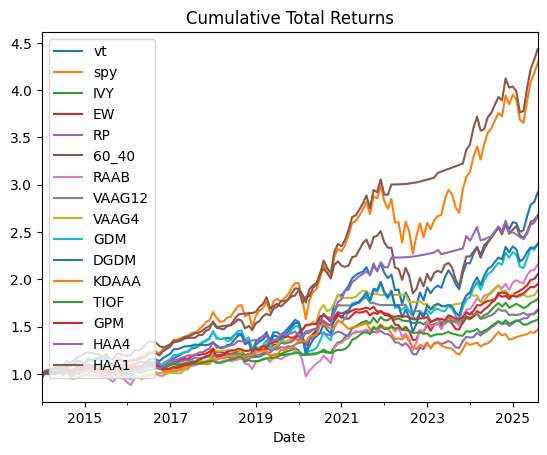

In [51]:
port_price_returns[port_price_returns.index >= "2014-01-01"].add(1).cumprod().plot(title="Cumulative Total Returns");

In [52]:
# list the annual returns of the strategies between 2011 and 2025
annual_returns = port_price_returns.resample("A").apply(lambda x: (x + 1).prod() - 1)
annual_returns = annual_returns.loc[annual_returns.index >= "2014-01-01"]
annual_returns
#annual_returns.plot.bar(title="Annual Returns of Strategies", figsize=(12, 6));

C:\Users\xawot\AppData\Local\Temp\ipykernel_44380\467404156.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_returns = port_price_returns.resample("A").apply(lambda x: (x + 1).prod() - 1)


,vt,spy,IVY,EW,RP,60_40,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA,TIOF,GPM,HAA4,HAA1
Date,,,,,,,,,,,,,,,,
2014-12-31,0.036801,0.134638,0.060057,0.046198,0.056494,0.190014,-0.024387,0.007718,-0.034625,0.137012,0.129999,0.019967,0.055418,0.045200,0.017383,0.074146
2015-12-31,-0.018614,0.012343,-0.037366,-0.044945,-0.023666,0.005805,-0.029040,-0.001448,-0.006291,-0.066053,0.000151,-0.037855,-0.006863,-0.018277,-0.030145,0.016264
2016-12-31,0.084975,0.119979,0.062379,0.073343,0.045095,0.080187,0.057603,0.043911,0.050438,0.068767,0.053520,0.045986,0.035972,0.023039,0.123298,0.158338
2017-12-31,0.244964,0.217054,0.102538,0.150417,0.099336,0.166079,0.146297,0.076481,0.137359,0.208977,0.101749,0.076431,0.046482,0.135992,0.143432,0.164217
2018-12-31,-0.097631,-0.045690,-0.016003,-0.038669,-0.003573,-0.029335,-0.084760,0.090725,0.112977,-0.079372,-0.066172,0.085752,-0.004345,0.052864,0.066481,0.116939
2019-12-31,0.268139,0.312239,0.080952,0.169805,0.108588,0.249434,0.179938,0.108560,0.100780,0.190106,0.255654,0.088653,0.076834,0.103985,0.072822,0.157246
2020-12-31,0.165878,0.183316,0.048409,0.164803,0.105323,0.198014,0.062905,0.264131,0.308092,0.037039,0.075349,0.197747,0.029494,0.180151,0.214522,0.247897
2021-12-31,0.182663,0.287288,0.201483,0.028291,0.005734,0.145727,0.133021,-0.000766,-0.001716,0.253109,0.192861,-0.025683,0.202416,0.017236,0.238201,0.287288
2022-12-31,-0.180034,-0.181754,-0.048812,-0.133225,-0.132540,-0.233069,-0.034493,-0.053977,-0.053709,-0.168293,-0.191265,-0.154845,-0.056281,-0.045601,0.036681,-0.003787


In [53]:
ts = Tearsheet(port_price_returns[port_price_returns.index >= "2014-01-01"], "EW")
ts.summary(ann_factor=12).round(2)

,vt,spy,IVY,EW,RP,60_40,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA,TIOF,GPM,HAA4,HAA1
#obs,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00
#years,11.58,11.58,11.58,11.58,11.58,11.58,11.58,11.58,11.58,11.58,11.58,11.58,11.58,11.58,11.58,11.58
Total Return,1.92,3.29,0.79,1.05,0.67,1.68,1.16,0.68,0.88,1.37,1.37,0.47,0.57,0.95,1.66,3.44
Annual Return,0.10,0.13,0.05,0.06,0.05,0.09,0.07,0.05,0.06,0.08,0.08,0.03,0.04,0.06,0.09,0.14
Volatility,0.14,0.15,0.06,0.08,0.06,0.11,0.12,0.06,0.07,0.12,0.14,0.08,0.05,0.06,0.08,0.09
Max Drawdown,-0.26,-0.24,-0.06,-0.18,-0.17,-0.26,-0.21,-0.14,-0.10,-0.20,-0.27,-0.23,-0.08,-0.10,-0.07,-0.09
Skewness,-0.43,-0.41,-0.19,-0.03,-0.10,-0.36,-0.19,0.48,0.15,-0.60,-0.50,-0.07,0.24,0.19,0.32,-0.02
Kurtosis,4.13,3.64,3.31,3.54,4.64,3.80,7.48,6.07,6.61,4.27,4.28,3.39,5.20,3.74,4.87,4.92
Sharpe Ratio,0.71,0.93,0.89,0.81,0.75,0.84,0.61,0.77,0.76,0.66,0.62,0.45,0.88,0.92,1.10,1.43
Standard Error,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.29,0.30,0.30,0.31,0.32


In [54]:
import numpy as np

next_rebal = rebalance_dates.max()
print(f"Next rebalance date: {next_rebal.date()}")
# extract the weights at that date (MultiIndex: Date, ID) -> index of asset IDs
try:
    weights_next = all_strategies.xs(next_rebal, level=0).fillna(0)
except Exception:
    # fall back to .loc in case of different structure
    weights_next = all_strategies.loc[next_rebal].fillna(0)
    # Ensure we have a DataFrame with columns per strategy and index=asset IDs

if isinstance(weights_next, pd.DataFrame):
    for strat in weights_next.columns:
        print(f"Strategy: {strat}")
        s = weights_next[strat]
        s_nonzero = s[s != 0]
        if s_nonzero.empty:
            print(" No positions (all zeros)")
        else:
            for asset, w in s_nonzero.items():
                print(f" {asset}: {w:.4f}")
        print("-" * 40)

Next rebalance date: 2025-08-29
Strategy: vt
 VT: 1.0000
----------------------------------------
Strategy: spy
 SPY: 1.0000
----------------------------------------
Strategy: IVY
 AGG: 0.2000
 DBC: 0.2000
 VEU: 0.2000
 VNQ: 0.2000
 VTI: 0.2000
----------------------------------------
Strategy: EW
 AGG: 0.2000
 EEM: 0.2000
 GLD: 0.2000
 IEF: 0.2000
 SPY: 0.2000
----------------------------------------
Strategy: RP
 No positions (all zeros)
----------------------------------------
Strategy: 60_40
 SPY: 0.6000
 TLT: 0.4000
----------------------------------------
Strategy: RAAB
 DBC: 0.1053
 EFA: 0.1053
 EFV: 0.4737
 IEF: 0.1053
 IWD: 0.1053
 MTUM: 0.1053
----------------------------------------
Strategy: VAAG12
 EEM: 0.1500
 EWJ: 0.1500
 GLD: 0.1500
 IWM: 0.1500
 LQD: 0.2500
 VGK: 0.1500
----------------------------------------
Strategy: VAAG4
 EEM: 1.0000
----------------------------------------
Strategy: GDM
 VEU: 1.0000
----------------------------------------
Strategy: DGDM
 AGG: 0.